## Import Data

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Load data
data = keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = data.load_data()

# Reshape and normalize data
X_train = (X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])) / 255
X_test = (X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])) / 255

4423680/4422102 [==============================] - 0s 0us/step


In [2]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

## Perceptron Benchmark

In [6]:
from sklearn.linear_model import Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, y_train)
print("Benchmark Accuracy : " + str(perceptron.score(X_test, y_test)))

Benchmark Accuracy : 0.7834


## MLP with Hyperparameter Optimization

In [8]:
# Split into training and validation sets for MLP
X_train, X_val = X_train[5000:], X_train[:5000]
y_train, y_val = y_train[5000:], y_train[:5000]

In [31]:
import kerastuner as kt

def build_model(hp):
    
    # Create a sequential MLP model
    model = keras.Sequential()
    
    # Input layer with 784 neurons
    model.add(keras.layers.Input(shape = (784,)))
    
    # Add batch normalization for normalizing input
    keras.layers.BatchNormalization()
    
    # Tune the number of TLU's in the first dense layer
    # First hidden layer with ReLU activation function and He initialization
    hp_units_1 = hp.Int("units_1", min_value = 64, max_value = 512, step = 64)
    model.add(keras.layers.Dense(units = hp_units_1, activation = "elu", 
                                 kernel_initializer = "he_normal", use_bias = False))
      
    # Add batch normalization for normalizing input
    keras.layers.BatchNormalization()
    
    # Tune the number of TLU's in the second dense layer
    # Second hidden layer with ReLU activation function and He initialization
    hp_units_2 = hp.Int("units_2", min_value = 64, max_value = 512, step = 64)
    model.add(keras.layers.Dense(units = hp_units_2, activation = "elu", 
                                 kernel_initializer = "he_normal", use_bias = False))
    
    # Add batch normalization for normalizing input
    keras.layers.BatchNormalization()
    
    # Output layer with 1 TLU per class (10) and softmax activation function
    model.add(keras.layers.Dense(10, activation = "softmax"))
    
    # Tune the learning rate for the optimizer 
    hp_learning_rate = hp.Choice("learning_rate", values = [1e-2, 1e-3, 1e-4]) 
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = keras.losses.SparseCategoricalCrossentropy(), metrics = ["accuracy"])
  
    return model

In [32]:
# Instantiate the tuner to perform the hypertuning using the hyperband tuner
tuner = kt.Hyperband(build_model,
                     objective = "val_accuracy", 
                     max_epochs = 10,
                     factor = 3, 
                     overwrite = True)

In [33]:
import IPython

# Define a callback to clear the training outputs at the end of every training step
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

# Run the hyperparameter search
tuner.search(X_train, y_train, epochs = 10, validation_data = (X_val, y_val), 
             callbacks = [ClearTrainingOutput(), keras.callbacks.EarlyStopping(patience = 5)], verbose = 0)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""The hyperparameter search is complete. The optimal number of TLU's in the first densely-connected
layer is {best_hps.get("units_1")}, the optimal number of TLU's in the second densely-connected
layer is {best_hps.get("units_2")}. The learning rate for the optimizer is {best_hps.get("learning_rate")}.""")

INFO:tensorflow:Oracle triggered exit
The hyperparameter search is complete. The optimal number of TLU's in the first densely-connected
layer is 384, the optimal number of TLU's in the second densely-connected
layer is 320. The learning rate for the optimizer is 0.001.


In [34]:
# Retrain the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs = 30, validation_data = (X_val, y_val), 
                    verbose = 0, callbacks = [keras.callbacks.EarlyStopping(patience = 5)])

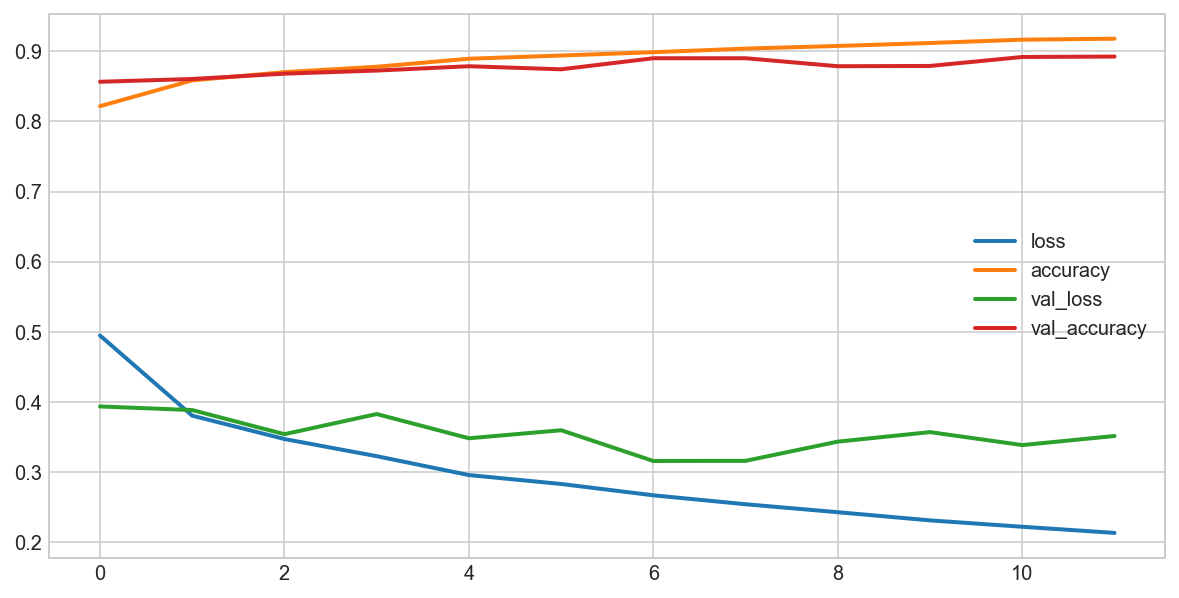

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
from matplotlib.pyplot import plot

# Set style for visualizations
style.use("seaborn-whitegrid")
%matplotlib inline
%config InlineBackend.figure_format = "retina"

# Plot loss and accuracy
pd.DataFrame(history.history).plot(figsize = (10,5), linewidth = 2)
plt.show()

In [36]:
# Evaluate performance on test data
model.evaluate(X_test, y_test)

313/313 [==============================] - ETA: 0s - loss: 0.8632 - accuracy: 0.87 - ETA: 0s - loss: 0.3551 - accuracy: 0.88 - ETA: 0s - loss: 0.3797 - accuracy: 0.88 - ETA: 0s - loss: 0.4001 - accuracy: 0.87 - ETA: 0s - loss: 0.4058 - accuracy: 0.87 - ETA: 0s - loss: 0.3964 - accuracy: 0.87 - 0s 925us/step - loss: 0.3921 - accuracy: 0.8812


[0.39212357997894287, 0.8812000155448914]